<ipython-input-2-421ff2fb8415>:45: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  hog_features = hog(img_lab, pixels_per_cell=(16, 16),
<ipython-input-2-421ff2fb8415>:45: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  hog_features = hog(img_lab, pixels_per_cell=(16, 16),


Test Image Path: HWData/test/buddha/image_0084.jpg
Test Image Label: buddha
Predicted Label: buddha


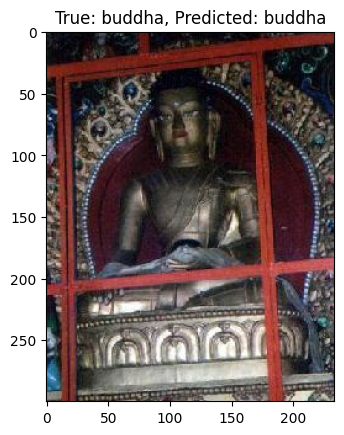

In [ ]:
import os
import numpy as np
import random
from skimage.io import imread
from skimage.color import rgb2lab, gray2rgb
from skimage.transform import resize
from skimage.feature import hog
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import zipfile

# Extract the HW4.zip file
with zipfile.ZipFile('HW4.zip', 'r') as zip_ref:
    zip_ref.extractall()

# Define directories
train_dir = 'HWData/train'
test_dir = 'HWData/test'

# Function to process images
def process_images(directory, is_train=True):
    data = []
    labels = []
    paths = []
    for class_dir in os.listdir(directory):
        if class_dir in ['binocular', 'beaver', 'camera', 'anchor', 'BACKGROUND_Google']:
            continue
        class_path = os.path.join(directory, class_dir)
        if os.path.isdir(class_path):
            img_files = os.listdir(class_path) if is_train else [random.choice(os.listdir(class_path))]
            for img_name in img_files:
                img_path = os.path.join(class_path, img_name)
                img = imread(img_path)

                # Ensure RGB format
                if len(img.shape) == 2:
                    img = gray2rgb(img)
                elif img.shape[2] == 4:
                    img = img[:, :, :3]

                img_resized = resize(img, (224, 224))  # Resize image to 224x224
                img_lab = rgb2lab(img_resized)  # Convert to LAB format

                # Extract HOG features
                hog_features = hog(img_lab, pixels_per_cell=(16, 16),
                                   cells_per_block=(2, 2),
                                   multichannel=True)

                data.append(hog_features)
                labels.append(class_dir)
                paths.append(img_path)
                if not is_train:  # Stop after one image for testing
                    break

    return np.array(data), np.array(labels), paths

# Process training images
X_train, y_train, _ = process_images(train_dir, is_train=True)

# Train the SVM classifier
svm_clf = SVC(kernel='linear', decision_function_shape='ovr')
svm_clf.fit(X_train, y_train)

# Process test images
X_test, y_test, test_image_paths = process_images(test_dir, is_train=False)


correct_prediction = False
while not correct_prediction:
    # Randomly select a test image
    random_idx = random.randint(0, len(X_test) - 1)
    test_image = X_test[random_idx].reshape(1, -1)
    test_label = y_test[random_idx]
    test_image_path = test_image_paths[random_idx]

    # Predict the label of the test image
    predicted_label = svm_clf.predict(test_image)[0]

    # Check if the prediction is correct
    if predicted_label == test_label:
        correct_prediction = True
        # Print the test image and the predicted label
        print(f'Test Image Path: {test_image_path}')
        print(f'Test Image Label: {test_label}')
        print(f'Predicted Label: {predicted_label}')

        # Load and display the test image
        test_image_display = imread(test_image_path)
        plt.imshow(test_image_display)
        plt.title(f'True: {test_label}, Predicted: {predicted_label}')
        plt.show()


